In [69]:
# !pip install matplotlib==3.4.3
# !pip install --upgrade statsmodels

# Module 7. Time series analysis

The book by Rajagopalan (2021) does not tackle the topic of time series analysis. Specialized books do exist on how to do time series analysis in Python, but those are too detailed for the time we can spend on the subject within the scope of this course. Hence, this notebook, and specifically the Python code you can find here can be used as an introduction on the topic.

## Introduction

Many decision-making applications depend on a forecast of some quantity.  
Unfortunately, forecasting is a very difficult task, both in the short and in the long run. Forecasts are usually based on historical data. Analysts look for patterns or relationships in the historical data and then make forecasts. There are two problems with this approach.  
The first is that it is not always easy to detect historical patterns or relationships. In particular, it is often difficult to separate the noise, or random behaviour, from the underlying patterns. Some forecasts may even exaggerate it, assigning importance to patterns that are in fact random variations and unlikely to recur.  
The second problem is that there are no guarantees that patterns from the past will continue in the future. A new war may break out somewhere in the world, the bottom may fall out of the stock market, ...


**Extrapolation Models**  
Extrapolation models are quantitative models that use historical data of a time series variable to predict future values of the variable. The idea is that historical movements of a variable, such as company sales or Belgian exports to Germany, can be used to predict future values of the variable.  
Many extrapolation models are available, including moving averages and exponential smoothing. These extrapolation models look for patterns in the historical series and then
extrapolate these patterns into the future. Some try to track upwards or downwards long-term
trends and then project them. Some try to follow seasonal patterns (such as an increase in sales in November and December, a decrease in other months) and then project them.


**Components of Time Series Data**  
There are four important
components of a time series. These components are called the trend component, the seasonal
component, the cyclic component, and the random (or noise) component.

Many time series have a **seasonal component**. For example, a company that sells swimming pool equipment sales increase each spring and then remain
relatively high in the summer, and then fall until next spring, after which the
annual pattern repeats itself. An important aspect of the seasonal component is that it tends to
be predictable from one year to the next. The same seasonal pattern tends to repeat itself every year.


A **cyclic pattern** exists when data exhibit rises and falls that are not of fixed period. For example, during a recession housing sales generally go down, unemployment goes up, stock prices go down, and so on. But when the recession is over, all of these variables tend to move in the opposite direction.
If the fluctuations are not of fixed period then they are cyclic; if the period is unchanging and associated with some aspect of the calendar, then the pattern is seasonal.

The **random component (or noise)** is the unpredictable component that gives most time series graphs their irregular, zigzag appearance.
Usually, a time series can be determined only to a certain extent by its trend, seasonal, and cyclic components. Then other factors determine the rest. These other factors can be inherent randomness, unpredictable "shocks" to the system, the unpredictable behavior of human beings who interact with the system, and possibly others.

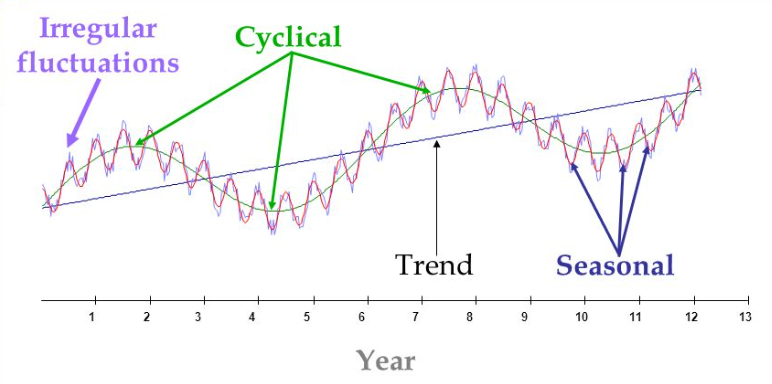

  The figure below shows the decomposition of the pregnancy number time series (top panel) into thee components: trend, seasonality, and residuals. [Published in Annual review of public health 2006
On time series analysis of public health and biomedical data.
S. Zeger, R. Irizarry, R. Peng]


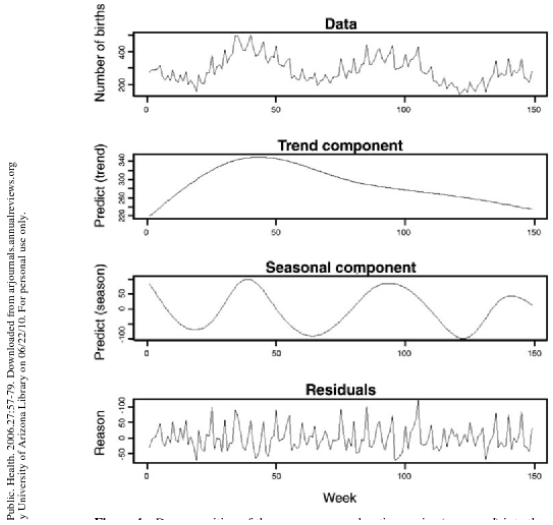

In [70]:
# Package imports
import numpy as np                                  # "Scientific computing"
import pandas as pd                                 # Dataframe

import scipy.stats as stats                         # Statistical tests
from sklearn.linear_model import LinearRegression   # Linear regression model

import matplotlib.pyplot as plt                     # Basic visualisation
from statsmodels.graphics.mosaicplot import mosaic  # Mosaic plot
import seaborn as sns                               # Advanced dataviz

In [72]:
immo = pd.read_csv('https://raw.githubusercontent.com/HoGentTIN/dsai-en-labs/main/data/immo_kwartaal_VL.csv', delimiter = ";")
immo.rename(columns = {'jaar':'year', 'periode':'quarter', 'aantal transacties':'number_of_transactions'}, inplace = True)
immo.head()

,year,quarter,number_of_transactions
0,2010,Q1,11 158
1,2010,Q2,12 343
2,2010,Q3,12 170
3,2010,Q4,12 073
4,2011,Q1,11 586


Add an extra column that is the combination of the year and the quarter.

In [73]:
immo['number_of_transactions'] = immo['number_of_transactions'].str.replace(" ", "").astype(float) / 100
immo['year_quarter'] = immo['year'].astype(str) + " " + immo['quarter']
immo.head()

,year,quarter,number_of_transactions,year_quarter
0,2010,Q1,111.58,2010 Q1
1,2010,Q2,123.43,2010 Q2
2,2010,Q3,121.70,2010 Q3
3,2010,Q4,120.73,2010 Q4
4,2011,Q1,115.86,2011 Q1


Add an extra column that is the end date of each quarter

In [74]:
d = {'Q1':'31/03', 'Q2':'30/06','Q3':'30/09','Q4':'31/12'}
immo['date'] = pd.to_datetime(immo['quarter'].map(d) + str("/") + immo['year'].astype(str))
immo.head()

,year,quarter,number_of_transactions,year_quarter,date
0,2010,Q1,111.58,2010 Q1,2010-03-31
1,2010,Q2,123.43,2010 Q2,2010-06-30
2,2010,Q3,121.70,2010 Q3,2010-09-30
3,2010,Q4,120.73,2010 Q4,2010-12-31
4,2011,Q1,115.86,2011 Q1,2011-03-31


In Python, a time series can be represented by an instance of the Pandas [`Series`](https://pandas.pydata.org/docs/reference/api/pandas.Series.html) class.

<AxesSubplot:>

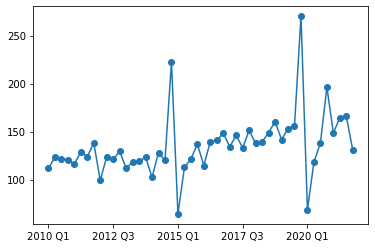

In [75]:
transactions_ts = pd.Series(
    data=np.array(immo['number_of_transactions']),
    index=np.array(immo['year_quarter'])
)
transactions_ts.plot(marker='o')

Columns in a `DataFrame` can also be processed as time series with the time/date as index.

<AxesSubplot:xlabel='date'>

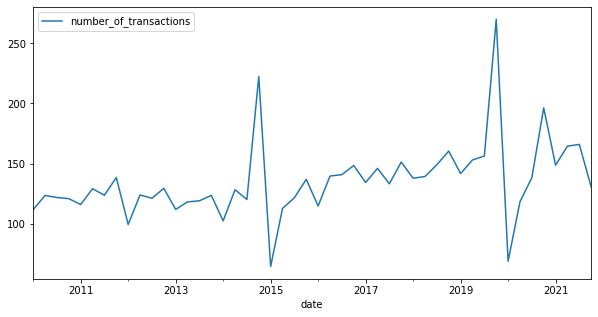

In [76]:
immo.plot(x='date', y='number_of_transactions', figsize=[10,5])

## Time series models

In the chart below, we attempt to model observed values with a constant function $X_t = b + \varepsilon_t$ (with $\varepsilon_t$ some random noise with constant variance). As an estimate for $b$, we take the average of the first observations. We can basically use our own judgement to choose how many.

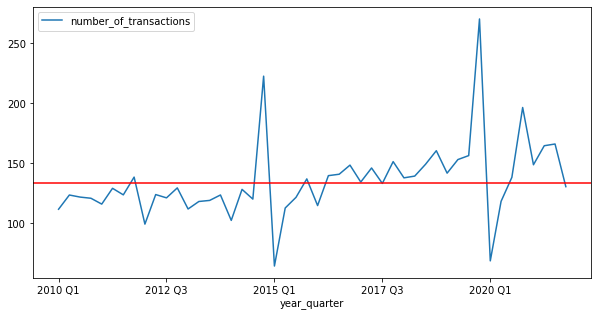

In [77]:
b_est_40 = immo['number_of_transactions'].head(40).mean()
b_est_50 = immo['number_of_transactions'].head(50).mean()

immo.plot(x='year_quarter', y='number_of_transactions', figsize=[10,5])
plt.axhline(y=b_est_40, color='red')   # Mean of first 40 observations
#plt.axhline(y=b_est_50, color='blue')  # Mean of first 50 observations

If we want to model these values with a linear function $X_t = b_0 + b_1 t + \varepsilon_t$, we can use a technique we actually already used in another context: linear regression. A linear trend means that the time series variable changes by a constant amount each time
period.

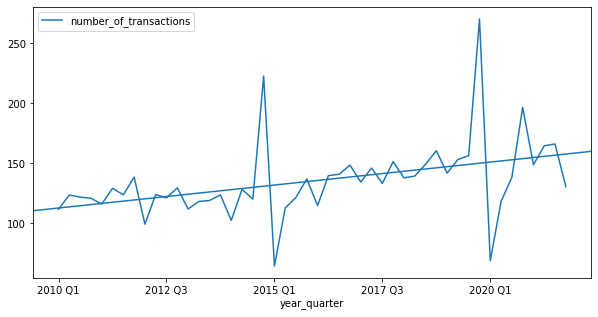

In [78]:
# Build a linear regression model
transactions_lm = LinearRegression().fit(
    immo['year_quarter'].index.values.reshape((-1,1)),
    immo['number_of_transactions'].values
)
# plot the time series and the regression line
immo.plot(x='year_quarter', y='number_of_transactions', figsize=[10,5])
plt.axline((0, transactions_lm.intercept_), slope=transactions_lm.coef_)

We can also use Seaborn's `regplot()` function to draw the regression line. We don't get the parameters, though...

<AxesSubplot:ylabel='number_of_transactions'>

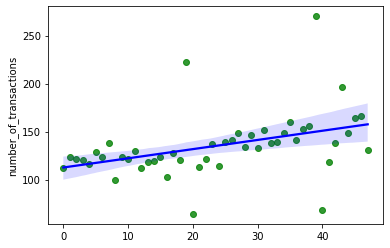

In [79]:

sns.regplot(x=immo['year_quarter'].index, y=immo['number_of_transactions'], line_kws={'color': 'b'}, scatter_kws={'color':'g'})


This estimate doesn't seem useful. Maybe it's useful to adapt our model when new observations are added?

## Moving average

We basically need a method that takes the last observations into account, but forgets observations after some time. Older observations may no longer be representative of the current situation. Moving averages are such methods.

### Simple Moving Average

$$SMA(t) = \frac{1}{m} \sum_{i=k}^{t} x_i$$

With $m$ the time range (the number of observations taken into account) and $k$ = t - m + 1.

Suppose the data are monthly and you choose a time range of six months.
Then the prediction of the next month's value is the average of the values for the past six months. For example, you average January to June to forecast July, you average February to July to forecast August, and so on. This procedure is the reason for the term moving averages.
The role of the time range is important. If the span is large—say, 12 months—then many observations go into each average, and extreme values have relatively little effect on the forecasts. The resulting series of forecasts will be much smoother than the original series.  
In contrast, if the
span is small—say, three months—then extreme observations have a larger effect on the forecasts,
and the forecast series will be much less smooth.

The Pandas `Series` class has a method [`rolling()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.rolling.html) for "rolling window" calculations, which is perfectly suitable for what we want to do here.

We call the method `rolling(m)` with the desired time range and then calculate the `mean()`:

In [80]:
immo['SMA3'] = immo['number_of_transactions'].rolling(3).mean()
immo['SMA5'] = immo['number_of_transactions'].rolling(5).mean()
immo['SMA10'] = immo['number_of_transactions'].rolling(10).mean()
immo

,year,quarter,number_of_transactions,year_quarter,date,SMA3,SMA5,SMA10
0,2010,Q1,111.58,2010 Q1,2010-03-31,NaN,NaN,NaN
1,2010,Q2,123.43,2010 Q2,2010-06-30,NaN,NaN,NaN
2,2010,Q3,121.70,2010 Q3,2010-09-30,118.903333,NaN,NaN
3,2010,Q4,120.73,2010 Q4,2010-12-31,121.953333,NaN,NaN
4,2011,Q1,115.86,2011 Q1,2011-03-31,119.430000,118.660,NaN
5,2011,Q2,129.02,2011 Q2,2011-06-30,121.870000,122.148,NaN
6,2011,Q3,123.56,2011 Q3,2011-09-30,122.813333,122.174,NaN
7,2011,Q4,138.35,2011 Q4,2011-12-31,130.310000,125.504,NaN
8,2012,Q1,99.18,2012 Q1,2012-03-31,120.363333,121.194,NaN
9,2012,Q2,123.81,2012 Q2,2012-06-30,120.446667,122.784,120.722


You'll notice that the first data points in the SMA columns are empty (`NaN`). At those time slots there are still not enough past observations to calculate the mean. The larger the time window, the more empty data points.

If you want to avoid empty cells, you can add the parameter `min_periods=1` to the method call of `rolling()`. In that case the mean will be calculated with any available past observation.

<AxesSubplot:xlabel='year_quarter'>

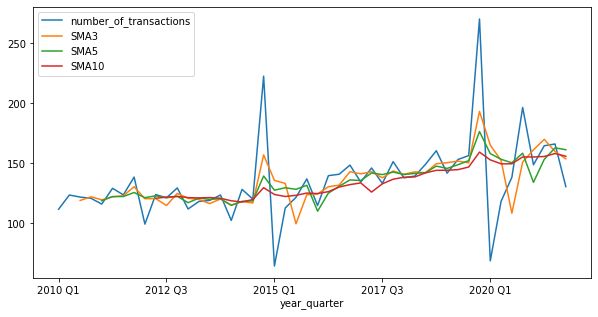

In [81]:
immo.plot(x='year_quarter', y=['number_of_transactions', 'SMA3',	'SMA5',	'SMA10'], figsize=[10,5])

As you will notice, SMA's with a short window will still follow fluctuations in the observations, while those with a longer window are more "stable", and resilient to short-term fluctuations.

There are two possible criticisms to the moving average method. First, it puts equal weight
on each value in a typical moving average. But one can argue that if the next month's
forecast should be based on the observations of the past 12 months, more weight should be
placed on the more recent observations. The second criticism is that the moving averages
method requires a lot of data storage.

**Exponential smoothing** is a method that addresses both points of criticism. It bases its
predictions on a weighted average of past observations, with more weight on the more recent
observations, and it requires very little data storage. Moreover, it is not difficult for most business people to understand, at least conceptually. Therefore, this method is widely used in the
business world, especially when frequent and automatic forecasts of many items are required.
There are many variations of exponential smoothing.
**Single exponential smoothing** is appropriate for a series with no pronounced trend or seasonality. **Holt's method** is appropriate for a series with trend but no seasonality.
**Winters' method** is appropriate for a series with seasonality (and possibly trend).

### Exponential Moving Average (EMA)

Also called *Single Exponential Smoothing* (SES).

$X_t = \alpha x_{t-1} + (1 - \alpha) X_{t-1}$

* $\alpha$ is the smoothing constant and is a number between 0 and 1
* $X_t$ is not observable but can onbly be estimated. Essentially, it is
an estimate of where the series would be at time _t_ if there were no random noise.

Pandas has a method [`ewm()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ewm.html) that can be used to calculate the exponential moving average.

<AxesSubplot:xlabel='year_quarter'>

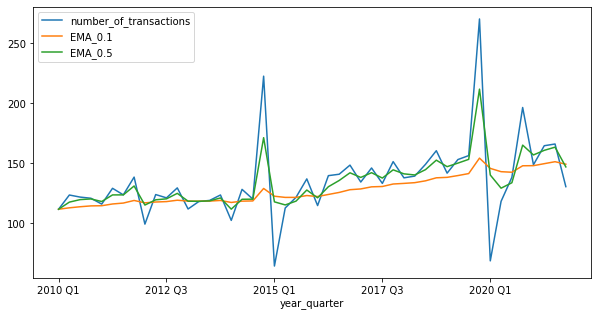

In [82]:
immo['EMA_0.1'] = immo['number_of_transactions'].ewm(alpha=.1, adjust=False).mean()
immo['EMA_0.5'] = immo['number_of_transactions'].ewm(alpha=.5, adjust=False).mean()
immo.plot(x='year_quarter', y=['number_of_transactions',  'EMA_0.1', 'EMA_0.5'], figsize=[10,5])

Play with the values of alpha. What is the effect if alpha is small (close to 0) or large (close to 1)?

A way to see the effect of α is to substitute recursively into the equation for $X_t$.  
By performing some algebra, you can verify that $X_t$ satifies the following equation, where sum extends back to the first observation at time = 1.

$X_t = \alpha x_{t-1} + \alpha (1 - \alpha) x_{t-2} + \alpha (1 - \alpha)^2 x_{t-3} + \alpha (1 - \alpha)^3 x_{t-4} + ...$

This equation shows how the exponentially smoothed forecast is a weighted average of previous observations. Furthermore, because 1 − $\alpha$ is less than 1, the weights on the x's decrease from time t backward.   
If $\alpha$ is close to 0, then 1 − $\alpha$ is close to 1 and the weights
decrease very slowly. In other words, observations from the distant past continue to have a large influence on the next forecast. This means that the graph of the forecasts will be relatively
smooth, just as with a large span in the moving averages method. But if $\alpha$ is close to 1, the weights decrease rapidly, and only very recent observations have much influence on
the next forecast. In this case forecasts react quickly to sudden changes in the series. 

Unfortunately, the `ewm()` method does not allow us to do double or triple exponential smoothing. Statsmodels does have the necessary classes. For Single Exponential Smoothing, we can instantiate the [`SimpleExpSmoothing`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.html#statsmodels.tsa.holtwinters.SimpleExpSmoothing) class and then call the [`fit()`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.fit.html#statsmodels.tsa.holtwinters.SimpleExpSmoothing.fit) method. The parameter $\alpha$ can be set with argument `smoothing_level`.

<AxesSubplot:xlabel='year_quarter'>

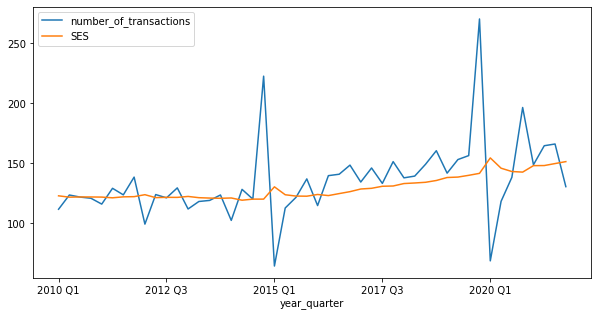

In [83]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
immo_ses = SimpleExpSmoothing(immo['number_of_transactions']).fit(smoothing_level=0.1)
immo['SES'] = immo_ses.fittedvalues
immo.plot(x='year_quarter', y=['number_of_transactions',  'SES'], figsize=[10,5])



These statsmodels classes allow us to do a prediction based on the model:

<AxesSubplot:xlabel='year_quarter'>

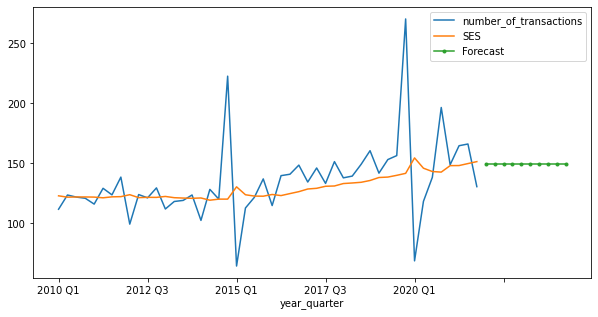

In [84]:
immo_ses_fcast = immo_ses.forecast(10)

immo.plot(x='year_quarter', y=['number_of_transactions',  'SES'], figsize=[10,5])
immo_ses_fcast.plot(marker='.', legend=True, label='Forecast')

When we use Single Exponential Smoothing, we assume that the underlying time series fluctutates around some constant value. This is reflected by the forecasted values (in green), which are always the same:

In [85]:
immo_ses_fcast.values

array([149.16394764, 149.16394764, 149.16394764, 149.16394764,
       149.16394764, 149.16394764, 149.16394764, 149.16394764,
       149.16394764, 149.16394764])

In [86]:
immo_ses.params_formatted

,name,param,optimized
smoothing_level,alpha,0.100000,False
initial_level,l.0,122.748825,True


### Double exponential smoothing

The single exponential smoothing model generally works well if there is no obvious trend in the series. But if there is a trend, this method consistently lags behind it. For example, if the series is constantly increasing, single exponential smoothing forecasts will be consistently
low.

If we suspect that there is a long-term (increasing or decreasing) trend in the time series, we can use Double Exponential Smoothing (DES), also called Holt's Method.

$$X_{t} = \alpha x_{t} + (1-\alpha)(X_{t-1} + b_{t-1})$$

$$b_{t} = \beta(X_{t}-X_{t-1}) + (1-\beta)b_{t-1}$$

with smoothing parameters $0 < \alpha < 1$ and $0 < \beta < 1$. $b_t$ is an estimate for the trend at time $t$ and can also be interpreted as the slope of a regression line.

The first equation says that the updated level is a weighted average of the current observation and the previous level plus the estimated change.
The second equation says that the updated trend is a weighted average of the difference between two consecutive levels and the previous trend.

Everything that was said about \alpha for single exponential smoothing applies to both \alpha and \beta in Holt's model. The new smoothing constant \beta controls how quickly the method reacts to observed changes in the trend. If \beta is small, the method reacts slowly. If it is large, the method reacts more quickly. 

In Python, you can instantiate the class [`Holt`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.Holt.html#statsmodels.tsa.holtwinters.Holt) and call the [`fit()`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.Holt.fit.html#statsmodels.tsa.holtwinters.Holt.fit) method. The smoothing parameters $\alpha$ and $\beta$ can be set with arguments `smoothing_level` and `smoothing_trend`, respectively. If you don't specify these, suitable values will be calculated using some rule of thumb.

<AxesSubplot:xlabel='year_quarter'>

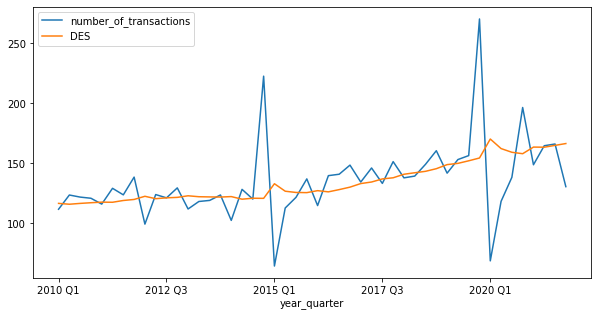

In [87]:
from statsmodels.tsa.api import Holt

immo_des = Holt(immo['number_of_transactions']).fit(smoothing_level=.1, smoothing_trend=.2)

immo['DES'] = immo_des.fittedvalues
immo.plot(x='year_quarter', y=['number_of_transactions',  'DES'], figsize=[10,5])


We can retrieve the parameters of the model (smoothing parameters, initial estimate of constant term and trend):

In [88]:
immo_des.params_formatted

,name,param,optimized
smoothing_level,alpha,0.100000,False
smoothing_trend,beta,0.200000,False
initial_level,l.0,116.588820,True
initial_trend,b.0,-0.128183,True


To use this model for forecasting:

<AxesSubplot:>

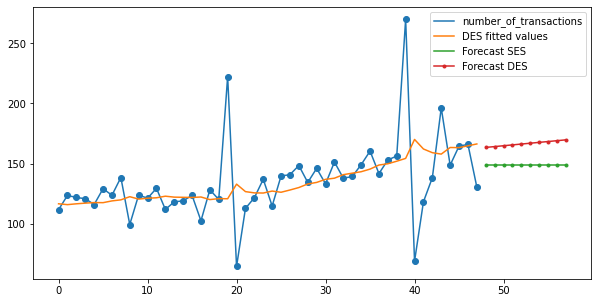

In [89]:
immo_des_fcast = immo_des.forecast(10)

immo['number_of_transactions'].plot(marker='o', legend=True) # Observations
immo['DES'].plot(legend=True, label='DES fitted values', figsize=[10,5])              
immo_ses_fcast.plot(marker='.', legend=True, label='Forecast SES')
immo_des_fcast.plot(marker='.', legend=True, label='Forecast DES') 

As we can see, the predictions are now increasing:

In [90]:
immo_des_fcast

48    163.410983
49    164.111235
50    164.811487
51    165.511739
52    166.211991
53    166.912242
54    167.612494
55    168.312746
56    169.012998
57    169.713250
dtype: float64

### Triple Exponential Smoothing

As mentioned in the introduction, seasonality is the consistent
month-to-month (or quarter-to-quarter) differences that occur each year. (It could also be the day-to-day differences that occur each week.) For example, there is seasonality toy sales, with
a huge peak in the months preceding Christmas.

How can you tell whether there is seasonality in a time series? The easiest way is to check whether a graph of the time series has a regular pattern of ups and/or downs in particular months or quarters.

To deal with seasonality, one can use (a.o.) Holt-Winters' exponential smoothing model. It is very similar to Holt's model—
it again has level and trend terms and corresponding smoothing constants $\alpha$ and $\beta$ —but it also has seasonal indexes and a corresponding smoothing constant $\gamma$ (gamma). This new
smoothing constant controls how quickly the method reacts to observed changes in the seasonality pattern. If $\gamma$ is small, the method reacts slowly. If it is large, the method reacts more
quickly. As with Holt's model, there are equations for updating the level and trend terms, and there is one extra equation for updating the seasonal indexes.

Triple Exponential Smoothing (TES), also called *Holt-Winter's Method*, can in addition also model seasonally recurring trends.

- Level smoothing: $X_{t} = \alpha \frac{x_{t}}{c_{t-L}} + (1-\alpha) (X_{t-1} + b_{t-1})$
- Trend smoothing: $b_{t} = \beta (X_{t} - X_{t-1}) + (1-\beta)b_{t-1}$ 
- Seasonal smoothing: $c_{t} = \gamma \frac{x_{t}}{X_{t}} + (1-\gamma)c_{t-L}$

In these formulas, the following additional notation is used:

- $L$ is the length (in number of time units) of the seasonal cycle. Common values are 7 for a weekly cycle, 4 for a quarterly one, 12 for a monthly cycle, etc.
- $0 < \gamma < 1$ is the smoothing parameter for the seasonal trend (like $\alpha$ and $\beta$). Set this value in the `fit()` method using argument `smoothing_seasonal`.
- $c_t$ are estimates for the seasonal correction factors, one for each time unit $t\mod L$ within the seasonal cycle.

Athough there is a small seasonal trend in the example dataset used in the previous sections, for clarity, we will use a demo dataset from Seaborn with air passenger data for 12 years from 1949 to 1960.

The dataset has two columns for the date (year and month). To make our lives a bit easier, we'll add a column with the date using Pandas' `date_range()` function. The `freq='MS'` parameter denotes that we want each consecutive date in the range to be the first day of the next month.

In [91]:
# Load the dataset
flights = sns.load_dataset('flights')
# Add a column for the date (last day of each month)
flights['date'] = pd.date_range(start="1949-01-01", freq='MS',
    periods=len(flights))

# Only keep the useful columns and set the index
flights = flights[['date', 'passengers']].set_index(['date'])
flights.head()

,passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


<AxesSubplot:xlabel='date'>

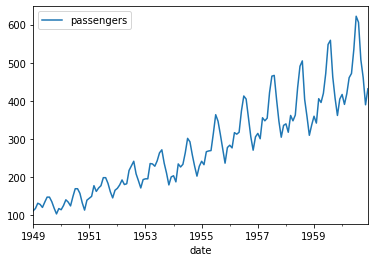

In [92]:
flights.plot()

Now we will fit the data with Holt-Winters Exponential Smoothing. We will train the model on the data from the first ten years and use the last two years as test data to check how the model performs.

The `ExponentialSmoothing` class allows us to train a model for all three types of Exponential Smoothing. It is in fact a superclass for `SimpleExpSmoothing` and `Holt`! When you add the parameter `trend`, it will enable Double Exponential Smoothing, and with `seasonal`, it will enable Triple Exponential Smoothing. When you don't specify either, a Simple Exponential Smoothing model will be built.

The value of `trend` and `seasonal` is a string and can be either `add`/`additive` or `mul`/`multiplicative`. When the long term or seasonal trend remains constant over time, use `add`. If, however, you see that the trend grows over time, use `mul`.

In this case, the long term trend looks linear, so we'll specify `trend='add'`. The seasonal trend, however, seems to grow over time, so we'll specify `season='mul'`.

The initial values for the level, trend and seasonal correction factors are calculated automatically using some rule of thumb. If you want to set them manually, though, you can by specifying arguments `initial_level`, `initial_trend` and `initial_seasonal` in the constructor call. See the [API documentation](https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.fit.html#statsmodels.tsa.holtwinters.ExponentialSmoothing.fit) for details.

If you want to set parameters $\alpha$, $\beta$ and $\gamma$ manually, you can add arguments to the [`fit()`](https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.fit.html#statsmodels.tsa.holtwinters.ExponentialSmoothing.fit) method call, specifically `smoothing_level` for $\alpha$, `smoothing_trend` for $\beta$ and `smoothing_seasonal` for $\gamma$. Again, if we don't specify them, a suitable value will be calculated automatically.

<AxesSubplot:xlabel='date'>

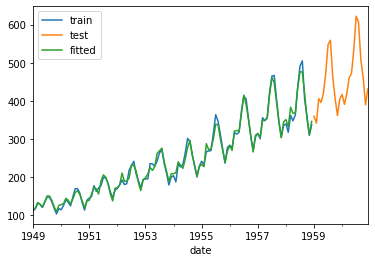

In [93]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

train = flights.passengers[:120]
test = flights.passengers[120:]

passengers_hw = ExponentialSmoothing(train,
  trend='add', seasonal='mul',
  seasonal_periods=12, freq='MS').fit()

train.plot(legend=True, label='train')
test.plot(legend=True, label='test')
passengers_hw.fittedvalues.plot(legend=True, label='fitted')

Our model seems to fit the data well. Let's use it to make a forecast. Generally, a forecast for $m$ time units after the last observation (time unit $t$) is calculated as follows:

$$F_{t+m} = (X_{t} + m b_{t})c_{t-L+1+(m-1) \mod L}$$


To understand the how the previous equation works, suppose you have observed data through June and you want a forecast for the coming September, that is, a three-month-ahead forecast. (In this case t refers to June and t + m = t + 3 refers to September.) The method first adds 3 times the current trend term to the current level. This gives a forecast
for September that would be appropriate if there were no seasonality. Next, it multiplies this forecast by the most recent estimate of September's seasonal index (the one from the
previous September) to get the forecast for September.

Applied to the airline passengers case, we calculate a forecast for the last two years (i.e. the test data) as follows:

Text(0.5, 1.0, 'Train, test, fitted & predicted values using Holt-Winters')

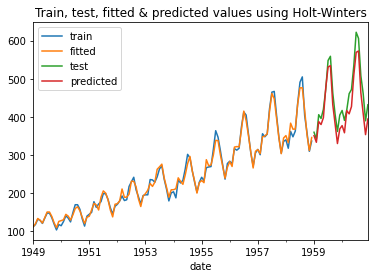

In [94]:
passengers_predicted = passengers_hw.forecast(24)

train.plot(legend=True, label='train')
passengers_hw.fittedvalues.plot(legend=True, label='fitted')

test.plot(legend=True, label='test')
passengers_predicted.plot(legend=True, label='predicted')

plt.title('Train, test, fitted & predicted values using Holt-Winters')


Let's zoom in on the forecasted period to compare test data and predictions:

Text(0.5, 1.0, 'Test data vs. predicted values')

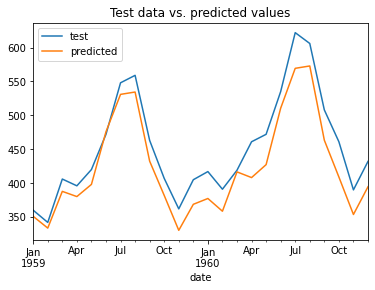

In [95]:
test.plot(legend=True, label='test')
passengers_predicted.plot(legend=True, label='predicted')
plt.title('Test data vs. predicted values')

In [96]:
passengers_predicted

1959-01-01    350.959380
1959-02-01    333.629378
1959-03-01    387.807281
1959-04-01    380.139393
1959-05-01    398.088914
1959-06-01    475.827979
1959-07-01    530.929189
1959-08-01    534.388628
1959-09-01    432.383521
1959-10-01    381.846229
1959-11-01    330.352965
1959-12-01    368.714468
1960-01-01    377.316496
1960-02-01    358.529176
1960-03-01    416.571646
1960-04-01    408.161811
1960-05-01    427.255332
1960-06-01    510.478475
1960-07-01    569.359028
1960-08-01    572.836954
1960-09-01    463.307349
1960-10-01    408.993859
1960-11-01    353.701315
1960-12-01    394.621506
Freq: MS, dtype: float64

### Model internals

We can retrieve the internals of the model. These are the relevant attributes:

- `level` contains all level estimates ($X_i$) for each time unit in the training data
- `trend` contains all trend estimates ($b_i$)
- `season` contains all estimates for the seasonal adjustment factors. ($c_i$)
- `params` (dict output) or `params_formatted` (table output) contains all parameters used to bootstrap the model (including automatically calculated ones).

In [97]:
# Retrieve the automatically calculated parameters of the model:
passengers_hw.params_formatted

,name,param,optimized
smoothing_level,alpha,0.364217,True
smoothing_trend,beta,0.000001,True
smoothing_seasonal,gamma,0.635782,True
initial_level,l.0,109.538064,True
initial_trend,b.0,2.360094,True
initial_seasons.0,s.0,1.000910,True
initial_seasons.1,s.1,1.051986,True
initial_seasons.2,s.2,1.156312,True
initial_seasons.3,s.3,1.100348,True
initial_seasons.4,s.4,1.018579,True


Forecasting is done using the final values for the level, trend and seasonal adjustment factor estimates. Let's retrieve them from the model:

In [98]:
# Model internals: last estimate for level, trend and seasonal factors:
print(f'level: {passengers_hw.level[35]}')
print(f'trend: {passengers_hw.trend[35]}')
print(f'seasonal factor: {passengers_hw.season[30:48]}')

level: 178.09515355330316
trend: 2.360071269592717
seasonal factor: date
1951-07-01    1.222876
1951-08-01    1.208459
1951-09-01    1.100924
1951-10-01    0.943222
1951-11-01    0.821918
1951-12-01    0.932298
1952-01-01    0.950948
1952-02-01    0.988551
1952-03-01    1.082316
1952-04-01    1.017177
1952-05-01    1.028135
1952-06-01    1.167524
1952-07-01    1.217092
1952-08-01    1.244267
1952-09-01    1.075673
1952-10-01    0.960841
1952-11-01    0.842915
1952-12-01    0.936893
dtype: float64


The model performs forecasts by:

- Taking the last level estimate
- Taking the last trend estimate
- Taking the last estimate for the appropriate seasonal adjustment factor
- Computing the forecast formula given above

Let's verify this for the first forecasted value, for 1959-01-01:

In [99]:
# Predicted value by forecast():
print(passengers_predicted[0])

# Computed manually from model internals:
(passengers_hw.level[119] + passengers_hw.trend[119]) * passengers_hw.season[108]

350.9593800085979


350.9593800085979

### Evaluating the quality of a model

How well did our model perform? We can compare the $m$ forecasted values with the observed values in the test set.

Two commonly used metrics for this are the Mean Absolute Error (MAE) and Mean Squared Error (MSE).

$$MAE = \frac{1}{m} \sum_{i=t+1}^{t+m} \left| x_i - F_i \right|$$

$$MSE = \frac{1}{m} \sum_{i=t+1}^{t+m} (x_i - F_i)^{2}$$

Remark the similarities between the formula for MSE and variance!

Applied to our case, we get:

In [100]:
passengers_predicted

1959-01-01    350.959380
1959-02-01    333.629378
1959-03-01    387.807281
1959-04-01    380.139393
1959-05-01    398.088914
1959-06-01    475.827979
1959-07-01    530.929189
1959-08-01    534.388628
1959-09-01    432.383521
1959-10-01    381.846229
1959-11-01    330.352965
1959-12-01    368.714468
1960-01-01    377.316496
1960-02-01    358.529176
1960-03-01    416.571646
1960-04-01    408.161811
1960-05-01    427.255332
1960-06-01    510.478475
1960-07-01    569.359028
1960-08-01    572.836954
1960-09-01    463.307349
1960-10-01    408.993859
1960-11-01    353.701315
1960-12-01    394.621506
Freq: MS, dtype: float64

In [101]:
test

date
1959-01-01    360
1959-02-01    342
1959-03-01    406
1959-04-01    396
1959-05-01    420
1959-06-01    472
1959-07-01    548
1959-08-01    559
1959-09-01    463
1959-10-01    407
1959-11-01    362
1959-12-01    405
1960-01-01    417
1960-02-01    391
1960-03-01    419
1960-04-01    461
1960-05-01    472
1960-06-01    535
1960-07-01    622
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Name: passengers, dtype: int64

In [102]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

print(f'MAE = {mean_absolute_error(test,passengers_predicted)}')
print(f'MSE = {mean_squared_error(test,passengers_predicted)}')

MAE = 28.977320257712137
MSE = 1055.5185492558428


In order to evaluate whether our model performs well, we can compare MSE with the variance in the data, or the square root of the MSE with the standard deviation:

In [103]:
print(f'√MSE  = {np.sqrt(mean_squared_error(test,passengers_predicted))}')
print(f'stdev = {flights.passengers.std()}')

√MSE  = 32.48874496276892
stdev = 119.96631694294321


The square root of the MSE is well within one standard deviation of the original data, which is an indicator that the model performs well.

A data scientist could try to tweak the parameters (like $\alpha$, $\beta$ and $\gamma$, but also initial values of the estimators like $X_t$, $b_t$ and $c_t$) of the model to attain an even lower MSE. When we are satisfied with the model's performance, we can start using it "in production". We could retrain the model with these parameters on the entire dataset and make forecasts for time units.

### Decomposing a time series

A data series that shows a long term and seasonal trend can be "decomposed":

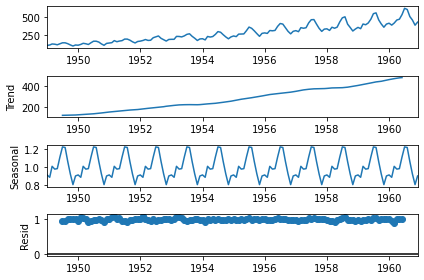

In [104]:
from statsmodels.tsa.seasonal import seasonal_decompose

passengers_decomposed = seasonal_decompose(flights, model='multiplicative')
passengers_decomposed.plot();

- The top graph shows the observations
- The second graph is the long term trend (which seems to be linear, so the choice for an additive model was appropriate)
- The third graph shows the seasonal trend
- The final graph are the residues

The semicolon at the end of line 4 is not strictly necessary, but if you leave it out, it's possible that the plot is shown twice.




## Sources

Khan, E. (2021-01-05) *Python Code on Holt-Winters Forecasting.* Retrieved 2022-04-15 from <https://medium.com/analytics-vidhya/python-code-on-holt-winters-forecasting-3843808a9873>

Moreno, A.I. (2020-07-08) *Moving Averages with Python: Simple, cumulative and exponential moving averages with Pandas*, retrieved 2022-04-15 from <https://towardsdatascience.com/moving-averages-in-python-16170e20f6c>

Paramita (2020-12-17) *Holt winters Model, Easiest Times series Model. Additive multiplicative trend and seasonality*, retrieved 2022-04-16 from <https://www.youtube.com/watch?v=O6cUkdQeLUQ>

Perktold, J., et al. (2022-04-13) *statsmodels manual: Exponential Smoothing.* Retrieved 2022-04-15 from <https://www.statsmodels.org/dev/examples/notebooks/generated/exponential_smoothing.html>